In [35]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Compare values from the MVP with the existing logger
--

Data from the existing logger is in

```waihaha.gns.cri.nz:/home/sysop/csi/inferno/2018``` with files like ```2018.034.Inferno-utc.csv```

In [36]:
import pandas as pd
%matplotlib inline

**Data files**

In [37]:
mvpfile = 'Table1.csv'
dtstart = '2018-05-07T05:50:00'

existfile = 'existing_logger.txt'

**Read data**

In [38]:
#MVP
df = pd.read_csv(mvpfile, parse_dates=True, index_col = 'Datetime')
#Use only data after logger was installed
mvp = df[df.index>=dtstart]

In [39]:
mvp.tail()

,RecNbr,LoggerName,SupplyVolts,LithiumVolts,PTemp_degC,Temp_PRT_degC,Depth_USGS_OTT_meters,nmbr_satellites_Avg
Datetime,,,,,,,,
2018-06-05 23:10:00,4279,Inferno,12.76,3.676,10.41,38.000000,3.872,7.5
2018-06-05 23:20:00,4280,Inferno,12.76,3.676,10.51,38.020000,3.873,8.0
2018-06-05 23:30:00,4281,Inferno,12.76,3.675,10.62,38.040001,3.876,8.0
2018-06-05 23:40:00,4282,Inferno,12.76,3.677,10.73,38.070000,3.876,8.0
2018-06-05 23:50:00,4283,Inferno,12.74,3.671,10.86,38.080002,3.879,8.0


**Get recent existing data**

In [40]:
%%bash
ssh volcano@waihaha "cat /home/sysop/csi/inferno/2018/2018.???.Inferno-utc.csv" > existing_logger_2018.txt

In [41]:
%%bash
cat existing_logger_2017.txt existing_logger_2018.txt > existing_logger.txt
#drop header lines
sed -i '/^I/ d; /^T/ d; /^C/ d' existing_logger.txt

In [42]:
#existing
names = ['date', 'time', 'temp', 'level']
exist = pd.read_csv(existfile, sep='\s+', skiprows=3, names=names, parse_dates={"Datetime" : ['date', 'time']}, usecols=[0,1,5,8], index_col = [0])
exist = exist[exist.index>=dtstart]

In [43]:
exist.tail()

,temp,level
Datetime,,
2018-06-05 21:00:00,38.21,-6.791
2018-06-05 21:15:00,38.24,-6.791
2018-06-05 21:30:00,38.22,-6.779
2018-06-05 21:45:00,38.23,-6.779
2018-06-05 22:00:00,38.23,-6.779


**Resample existing data on same time scale as MVP**

In [44]:
exist1 = exist.resample('10T')
exist2 = exist1.interpolate(method='linear')

In [45]:
exist2.tail()

,temp,level
Datetime,,
2018-06-05 21:20:00,38.216667,-6.783
2018-06-05 21:30:00,38.220000,-6.779
2018-06-05 21:40:00,38.223333,-6.779
2018-06-05 21:50:00,38.226667,-6.779
2018-06-05 22:00:00,38.230000,-6.779


**Temperature**

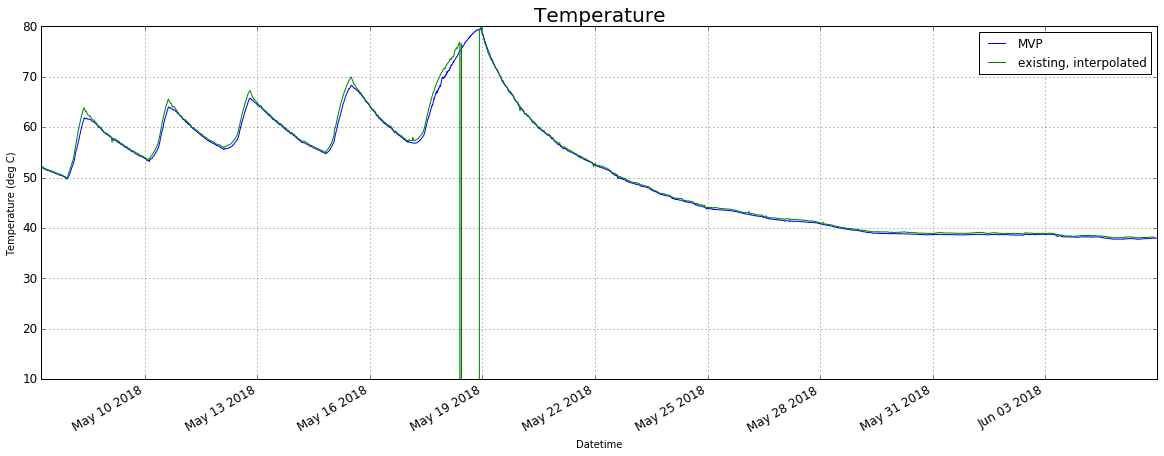

In [46]:
tmp = mvp['Temp_PRT_degC'].plot(figsize=(20,7), title='Temperature', label='MVP', fontsize=12)
exist2['temp'].plot(ax=tmp, label='existing, interpolated')
tmp.title.set_size(20)
tmp.grid()
tmp.set_ylabel("Temperature (deg C)")
tmp.set_ylim(ymin=10, ymax=80)
tmp.legend(loc='best')

In [47]:
fig = tmp.get_figure()
fig.savefig('temperature_compare.png', dpi=100)

**Temperature difference**

In [48]:
diff = mvp['Temp_PRT_degC'] - exist2['temp']
diff.describe()

count    4272.000000
mean      133.169324
std      1028.663140
min        -2.473334
25%        -0.316666
50%        -0.251667
75%        -0.193331
max      8269.419998
dtype: float64

**Depth**

In [49]:
diff = mvp['Depth_USGS_OTT_meters'] - exist2['level']
diff.mean()
exist2['level'] += diff.mean()

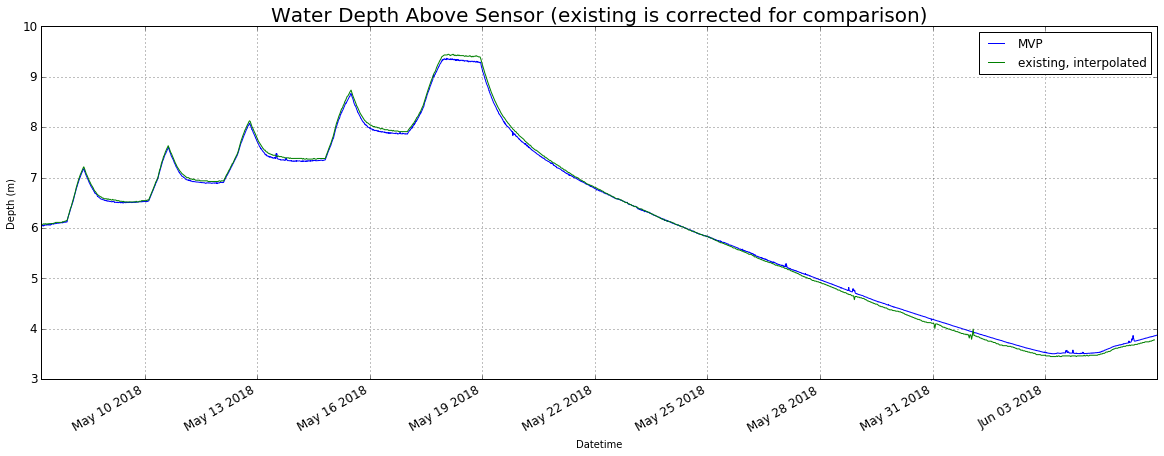

In [50]:
dep = mvp['Depth_USGS_OTT_meters'].plot(figsize=(20,7), title='Water Depth Above Sensor (existing is corrected for comparison)',fontsize=12, label='MVP')
exist2['level'].plot(ax=dep, label='existing, interpolated')
dep.title.set_size(20)
dep.grid()
dep.set_ylabel("Depth (m)")
dep.legend(loc='best')

In [51]:
fig = dep.get_figure()
fig.savefig('depth_compare.png', dpi=100)